# HW #1 Futures Spreads Dynamiccs
[FINM 33150] Regression Analysis and Quantitative Trading Strategies\
Winter 2022 | Professor Brian Boonstra

_**Due:** Sunday, January 16th, at 11:00pm\
**Name:** Ashley Tsoi (atsoi, Student ID: 12286230)_

### 1. Fetch and clean data

#### 1-1. Install these packages for the first time

In [1]:
# !pip install quandl
# !pip install plotnine

#### 1-2. Import packages

In [22]:
import quandl
import json
import pandas as pd
pd.set_option("display.precision", 4)
import numpy as np
import datetime as dt
import functools

# let plot display in the notebook instead of in a different window
%matplotlib inline 
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as p9

#### 1-3. Define the functions to fetch data from Quandl

**1-3-1. Get my personal keys** from ../data/APIs.json

In [3]:
f = open('../data/APIs.json')
APIs = json.load(f)
f.close()

**1-3-2. Define helper function** to validate date format

In [4]:
def assertCorrectDateFormat(date_text):
    try:
        dt.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect date format, should be YYYY-MM-DD")

**1-3-3. Define function** to retrieve raw data from Quandl

**Documentation:**
```
https://data.nasdaq.com/data/OWF-optionworks-futures-options/documentation
```

In [5]:
# Define function that retrieves data from Quandl
def getQuandlData(secs,start_date,end_date,column_index=False):
    # Get data fom Quandl using quandl.get
    # NOTE: missing data for the inputted date will return NaN rows.

    # INPUT         | DATA TYPE                 | DESCRIPTION
    # secs          | string / tuple of string  | security name(s)
    # start_date    | string (YYYY-MM-DD)       | start date of data
    # end_date      | string (YYYY-MM-DD)       | end date of data (same as or after start_date)
    # column_index  | False / string (int)      | index of a single column; False means select all columns

    # Input validation
    assertCorrectDateFormat(start_date)
    assertCorrectDateFormat(end_date)
    assert end_date >= start_date
    
    if type(secs) is tuple: secs=list(secs)
    # Retrieve data using quandl.get
    if column_index: # if only select one column
        data = quandl.get(secs, returns="pandas",
                          api_key=APIs['Quandl'],
                          column_index=column_index,
                          start_date=start_date, end_date=end_date)
    else:
        data = quandl.get(secs, returns="pandas",
                          api_key=APIs['Quandl'],
                          start_date=start_date, end_date=end_date)

    return data

**1-3-4. Define functions** to get cleaned, second month quarterly futures prices

1. Select the rows needed (i.e. lowest "DtT" that is greater than 30)
2. Select the columns needed (i.e. column names that end with " - Future")
3. Rename the column to the security name
4. Forward-fill `NaN` values

In [6]:
@functools.lru_cache(maxsize=16) # Cache the function output
def _getOneSecondMonthQFuturesPrice(security,start_date,end_date):
    # For 1 future, return its second month quarterly prices from Quandl (Pandas Series)
    # Rows: security with minimum DtT (Date to Termination) that is greater than 30
    
    quarterly_codes = "HMUZ" # H: March, M: June, U: September, Z: December (see more month codes: https://www.cmegroup.com/month-codes.html#)
    year_range = [str(y) for y in range(int(start_date[:4]), int(end_date[:4])+1)] # get all years between start_date and end_date
    
    # construct all security codes for the quarter / year combination
    quarterly_secs = []
    for qc in quarterly_codes:
        for year in year_range:
            quarterly_secs.append("OWF/" + security + "_" + qc + year + "_IVM") # e.g. OWF/ICE_T_T_H2020_IVM
    
    print("START | Retriving Quandl data for securities: \n",quarterly_secs)
    
    # for all security codes, find their data
    data = []
    for s in quarterly_secs:
        prices = getQuandlData(s,start_date,end_date,'1')
        DtT = getQuandlData(s,start_date,end_date,'16') # need "DtT" column to do row selection

        secData = pd.concat([prices,DtT], axis=1)
        secData = secData.loc[secData["DtT"] > 30] # select the rows where DtT is greater than 30
        secData.reset_index(level=0, inplace=True) # make "Date" index into a column
        data.append(secData)
    
    data = pd.concat(data).reset_index(drop=True)

    # select 1 row per date with min DtT 
    data = data.loc[data.groupby("Date").DtT.idxmin()]

    # make "Date" the index again and rename column to the security name (as inputted)
    data.set_index('Date', inplace=True)
    data.rename(columns={'Future': security}, inplace=True)
    data.fillna(method='ffill', inplace=True) # forward-fill NaN data

    print("DONE  | Retrieved {:d} dates of data for {}.\n".format(len(data),security))

    return data[security]


**1-3-5. Define functions** to make spreads from a pair of securities

In [7]:
def getSpread(sec1,sec2,start_date,end_date,multiplier=1):
    # Return spreads: sec2*multiplier - sec1
    sec1Prices = _getOneSecondMonthQFuturesPrice(sec1,start_date,end_date)
    sec2Prices = _getOneSecondMonthQFuturesPrice(sec2,start_date,end_date)

    return pd.DataFrame((sec2Prices*multiplier)-sec1Prices, columns=[sec1+' | '+sec2])

#### 1-4. Fetch cleaned spread data using functions above

Last 2 unique digits of my student ID: 3, 0

**Securities:**
```
Pair #3: ICE_T_T ICE_G_G 0.1342281879194631 (1/7.45)
Pair #0: ICE_B_B ICE_G_G 0.1342281879194631 (1/7.45)
```

**Securities Description:**
```
ICE_T_T - WTI Crude Oil
ICE_G_G - Gas Oil G
ICE_B_B - Brent Crude Oil
```

**Dates:**
```
December 3, 2019 - August 31, 2021
```

In [23]:
spread_3 = getSpread('ICE_T_T','ICE_G_G','2019-12-03','2021-08-31',multiplier=1/7.45)
spread_0 = getSpread('ICE_B_B','ICE_G_G','2019-12-03','2021-08-31',multiplier=1/7.45)
spreads = pd.concat([spread_3,spread_0],axis=1)
spreads

,ICE_T_T | ICE_G_G,ICE_B_B | ICE_G_G
Date,,
2019-12-03,20.3881,16.0981
2019-12-04,19.5103,15.3503
2019-12-05,20.1615,15.7415
2019-12-06,19.9113,15.3013
2019-12-09,20.0177,15.3777
...,...,...
2021-08-25,10.6621,7.7321
2021-08-26,11.4644,8.5844
2021-08-27,11.2524,8.3124


**Data check:**

The below data should match the numbers given in the assignment.

In [24]:
spreads.loc[['2021-01-19','2021-01-20','2021-02-08','2021-02-09']]

,ICE_T_T | ICE_G_G,ICE_B_B | ICE_G_G
Date,,
2021-01-19,8.9663,6.4263
2021-01-20,9.2799,6.4199
2021-02-08,9.3265,6.6065
2021-02-09,9.4199,6.7199


The data matches exactly what is given! Now we can continue to the analysis.

### 2. Analysis
#### 2-1. Characterize the relative dynamics of $s^{(i)}_t$

Examine more quantiles than just the median. Look at tails. 
Do the spreads correlate? How about their difference $(d)$ values? Do spreads exhibit patterns over time?

**2-1-1. Add difference between the spread & the spread returns**

The "returns" for the spread pair (of securities `A` & `B`) would be the profit if we buy a share of `B` and sell a share of `A`.

In [38]:
# Add the difference between the 2 spreads
spreads['d'] = spreads['ICE_T_T | ICE_G_G']-spreads['ICE_B_B | ICE_G_G']

# Get the returns data
spreads_ret = spreads.pct_change()[1:] # drop the first "NaN" row, should now start from 2019-12-04
spreads_ret

,ICE_T_T | ICE_G_G,ICE_B_B | ICE_G_G,d
Date,,,
2019-12-04,-0.0431,-0.0464,-0.0303
2019-12-05,0.0334,0.0255,0.0625
2019-12-06,-0.0124,-0.0280,0.0430
2019-12-09,0.0053,0.0050,0.0065
2019-12-10,0.0132,0.0210,-0.0129
...,...,...,...
2021-08-25,-0.0211,-0.0300,0.0034
2021-08-26,0.0752,0.1102,-0.0171
2021-08-27,-0.0185,-0.0317,0.0208


**2-1-2. Define analysis functions**

In [39]:
def getStats(data,annual_factor=1):

    data_desc = data.describe().loc[['count','mean', 'max', 'min', 'std']]

    data_desc.loc['mean'] = data_desc.loc['mean']*annual_factor
    data_desc.loc['vol'] = data_desc.loc['std']*np.sqrt(annual_factor)
    data_desc.loc['sharpe_ratio'] = data_desc.loc['mean']/data_desc.loc['vol']

    data_desc.loc['skewness'] = data.skew()
    data_desc.loc['excess_kurtosis'] = data.kurt()-3
    data_desc.loc['VaR05'] = np.quantile(data, .05, axis=0)
    data_desc.loc['CVaR05'] = np.mean(data <= data_desc.loc['VaR05'])

    return data_desc
    

**2-1-3. General analysis of prices and returns of the spreads**

First look at the basic statistics of the prices and returns:

In [41]:
stats = pd.concat([getStats(spreads),getStats(spreads_ret,annual_factor=4)], axis=1)
stats.columns = pd.MultiIndex.from_arrays([['Prices']*3+['Returns']*3, stats.columns])
stats


Prices                              \
                ICE_T_T | ICE_G_G ICE_B_B | ICE_G_G         d   
count                    450.0000          450.0000  450.0000   
mean                      10.1931            7.1850    3.0081   
max                       22.0836           18.0436    9.8900   
min                        3.1376            1.2038   -0.9600   
std                        4.0781            3.5258    1.3401   
vol                        4.0781            3.5258    1.3401   
sharpe_ratio               2.4995            2.0378    2.2446   
skewness                   1.2007            1.0962    1.6819   
excess_kurtosis           -1.9598           -1.9902    5.2121   
VaR05                      4.9797            2.3591    1.8600   
CVaR05                     0.0511            0.0511    0.0556   

                          Returns                              
                ICE_T_T | ICE_G_G ICE_B_B | ICE_G_G         d  
count                    449.0000          449.0000  449.0000  
mean                       0.0193            0.0587    0.1667  
max                        0.5500            1.0536   10.0000  
min                       -0.4526           -0.6093   -1.2030  
std                        0.1095            0.1859    0.5701  
vol                        0.2190            0.3717    1.1403  
sharpe_ratio               0.0881            0.1579    0.1462  
skewness                   0.3606            1.4675   13.5298  
excess_kurtosis            0.4911            4.1355  215.4582  
VaR05                     -0.1609           -0.2376   -0.1298  
CVaR05                     0.0512            0.0512    0.0512

**The `mean`, `volatility`, and `sharpe_ratio` for "Returns" are annualized.*

Compared to the `ICE_B_B | ICE_G_G` (Brent Crude Oil - Gas Oil G) pair (pair #3), the `ICE_T_T | ICE_G_G` (WTI Crude Oil - Gas Oil G) pair (pair #0) has a higher mean of about $10.19 from 2019-12-03 to 2021-08-31. However, pair #0 has a lower annualized return (1.93%) compared to pair #3 (5.87%). With a lower volatility of 21.9%, pair #0 has an even higher sharpe ratio of 8.81%. 

Next, let's see the time-series plots of the prices and returns, as well as their rolling averages.

<AxesSubplot:title={'center':'Futures Spread Rolling Average Prices (window=50)'}, xlabel='Date', ylabel='Prices ($)'>

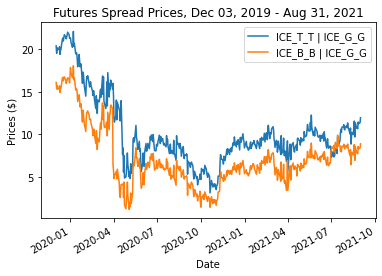

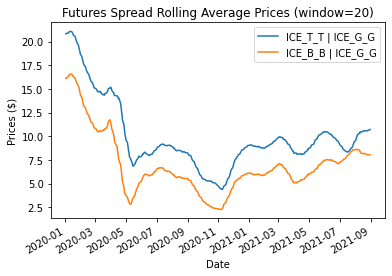

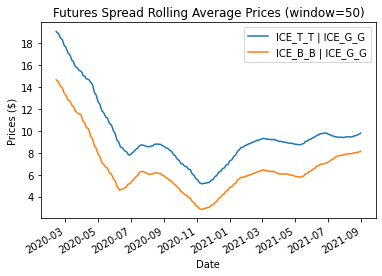

In [14]:
spreads.plot(ylabel="Prices ($)",title='Futures Spread Prices, Dec 03, 2019 - Aug 31, 2021')
spreads.rolling(20).mean()[20:].plot(ylabel="Prices ($)",title='Futures Spread Rolling Average Prices (window=20)')
spreads.rolling(50).mean()[50:].plot(ylabel="Prices ($)",title='Futures Spread Rolling Average Prices (window=50)')
spreads.rolling(100).mean()[100:].plot(ylabel="Prices ($)",title='Futures Spread Rolling Average Prices (window=100)') # Since there are roughly 100 days in a quarter

For the pricing data, it does seem the two spreads are correlated.

<AxesSubplot:title={'center':'Futures Spread Rolling Average Returns (window=100)'}, xlabel='Date', ylabel='Returns'>

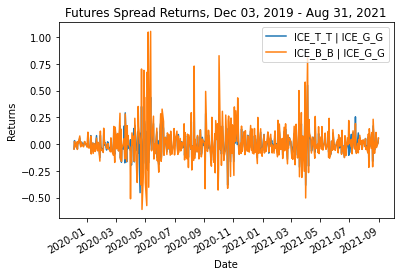

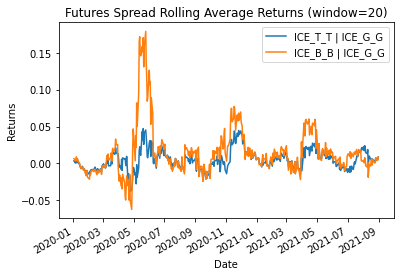

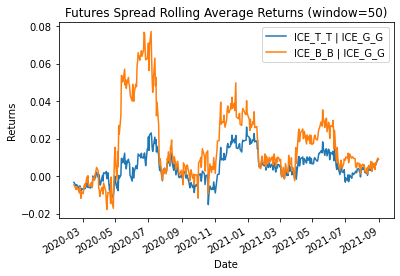

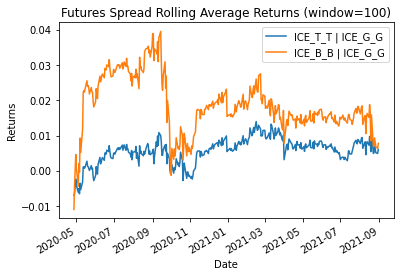

In [32]:
spreads_ret.plot(ylabel="Returns",title='Futures Spread Returns, Dec 03, 2019 - Aug 31, 2021')
spreads_ret.rolling(20).mean()[20:].plot(ylabel="Returns",title='Futures Spread Rolling Average Returns (window=20)')
spreads_ret.rolling(50).mean()[50:].plot(ylabel="Returns",title='Futures Spread Rolling Average Returns (window=50)')
spreads_ret.rolling(100).mean()[100:].plot(ylabel="Returns",title='Futures Spread Rolling Average Returns (window=100)') # Since there are roughly 100 days in a quarter

In [ ]:


spreads.plot(ylabel="Prices ($)",title='Futures Spread Prices, Dec 03, 2019 - Aug 31, 2021')
spreads.rolling(20).mean()[20:].plot(ylabel="Prices ($)",title='Futures Spread Rolling Average Prices (window=20)')
spreads.rolling(50).mean()[50:].plot(ylabel="Prices ($)",title='Futures Spread Rolling Average Prices (window=50)')
spreads.rolling(100).mean()[100:].plot(ylabel="Prices ($)",title='Futures Spread Rolling Average Prices (window=100)') # Since there are roughly 100 days in a quarter